# Flow-Matching + PPO Rotation Alignment (Tetris)

Variant A: use the **frozen flow-matching rotator** as the environment dynamics.
The PPO agent learns to steer the rotation (action sequence) and then commit
**match** or **mismatch** at the end for evaluation.

This mirrors `notebooks/ppo_tetris.ipynb` but replaces Kornia rotation with the
strongest FM model (`models/rotator_l1_500e_10k.pth`).

In [1]:
%cd /Users/masha/Documents/visual-reasoning

/Users/masha/Documents/visual-reasoning


In [5]:
import math
import random
from typing import Callable, Optional, Tuple

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm
import os

import kornia as K
import gymnasium as gym

from stable_baselines3 import PPO

Utility helpers: device selection, seeding, state builder, and a Kornia rotation helper
(used only to generate the synthetic source/target pairs).

In [6]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def build_state(source: torch.Tensor, target: torch.Tensor, angle_deg=None) -> torch.Tensor:
    # Build state by concatenating source, target, and a constant angle channel.
    # Handles batch expansion of target/angle if needed.
    if source.dim() == 3:
        source = source.unsqueeze(0)
    if target.dim() == 3:
        target = target.unsqueeze(0)
    if target.shape[0] == 1 and source.shape[0] > 1:
        target = target.expand(source.shape[0], -1, -1, -1)

    state = torch.cat([source, target], dim=1)

    if angle_deg is None:
        return state

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=state.device, dtype=state.dtype)
    else:
        angle = angle_deg.to(device=state.device, dtype=state.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and state.shape[0] > 1:
        angle = angle.repeat(state.shape[0])

    angle_norm = (angle % 360.0) / 360.0
    angle_ch = angle_norm.view(-1, 1, 1, 1).expand(-1, 1, state.shape[2], state.shape[3])
    return torch.cat([state, angle_ch], dim=1)


def rotate_tensor(img: torch.Tensor, angle_deg, pad_to_diag: bool = True) -> torch.Tensor:
    # Rotate image(s) by angle(s) in degrees using kornia.
    # If pad_to_diag=True, pad to the diagonal size before rotating, then center-crop.
    if img.dim() == 3:
        img_b = img.unsqueeze(0)
    else:
        img_b = img

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=img_b.device, dtype=img_b.dtype)
    else:
        angle = angle.to(device=img_b.device, dtype=img_b.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and img_b.shape[0] > 1:
        angle = angle.repeat(img_b.shape[0])

    b, c, h, w = img_b.shape
    if pad_to_diag:
        diag = int(math.ceil(math.sqrt(h * h + w * w)))
        pad_h = max(0, diag - h)
        pad_w = max(0, diag - w)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        if pad_h > 0 or pad_w > 0:
            img_p = F.pad(img_b, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=0.0)
        else:
            img_p = img_b
    else:
        img_p = img_b

    rotated = K.geometry.transform.rotate(img_p, angle)

    if pad_to_diag:
        hh, ww = h, w
        y0 = (rotated.shape[2] - hh) // 2
        x0 = (rotated.shape[3] - ww) // 2
        rotated = rotated[:, :, y0:y0 + hh, x0:x0 + ww]

    return rotated if img.dim() == 4 else rotated.squeeze(0)


device = get_device()
print("Device:", device)

Device: mps


Frozen Flow-Matching rotator (FastRotator) + DINO embedding.
The FM model expects **1-channel inputs in [-1, 1]**. We keep it frozen and use
it purely as a rotation dynamics model.

In [7]:
DEVICE = device
MODEL_PATH = "models/rotator_l1_500e_10k.pth"

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class FastRotator(nn.Module):
    def __init__(self, backbone_dim=384, flow_dim=64):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.angle_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.cond_proj = nn.Linear(backbone_dim, flow_dim*4)

        self.inc = DoubleConv(1, flow_dim)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim, flow_dim*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim*2, flow_dim*4))

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(flow_dim*6, flow_dim*2)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = DoubleConv(flow_dim*3, flow_dim)

        self.outc = nn.Conv2d(flow_dim, 1, kernel_size=1)

    def forward(self, x_t, t, dino_emb, target_angle_deg):
        t_emb = self.time_mlp(t)
        d_emb = self.cond_proj(dino_emb)
        a_emb = self.angle_mlp(target_angle_deg / 360.0)
        global_cond = (t_emb + d_emb + a_emb).unsqueeze(-1).unsqueeze(-1)

        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x3 = x3 + global_cond

        x = self.conv1(torch.cat([self.up1(x3), x2], dim=1))
        x = self.conv2(torch.cat([self.up2(x), x1], dim=1))
        return self.outc(x)

fm_model = FastRotator().to(DEVICE)
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(MODEL_PATH)
fm_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
fm_model.eval()
for p in fm_model.parameters():
    p.requires_grad = False

dino = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()
for p in dino.parameters():
    p.requires_grad = False

@torch.no_grad()
def get_dino_embedding(img_64_tensor: torch.Tensor, dino_model: nn.Module = None) -> torch.Tensor:
    # img_64_tensor: (B, 1, 64, 64) in [-1, 1]
    if dino_model is None:
        dino_model = dino
    img = (img_64_tensor * 0.5) + 0.5
    img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
    img = img.repeat(1, 3, 1, 1)
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = norm(img)
    emb = dino_model.forward_features(img)[:, 0, :]
    return emb

@torch.no_grad()
def apply_rotation_fm(model, base_img, base_emb, angle_deg, steps=10):
    # base_img: (B, 1, 64, 64) in [-1, 1]
    model.eval()
    dt = 1.0 / steps
    curr = base_img.clone()
    B = base_img.shape[0]
    target_ang = torch.full((B, 1), float(angle_deg), device=base_img.device, dtype=base_img.dtype)
    for i in range(steps):
        t = torch.full((B, 1), i / steps, device=base_img.device, dtype=base_img.dtype)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
    return curr

@torch.no_grad()
def apply_rotation_fm_delta(model, curr_img, base_emb, delta_deg, steps=5):
    # Apply a small delta rotation starting from the current image.
    model.eval()
    dt = 1.0 / steps
    curr = curr_img.clone()
    B = curr.shape[0]
    target_ang = torch.full((B, 1), float(delta_deg), device=curr.device, dtype=curr.dtype)
    for i in range(steps):
        t = torch.full((B, 1), i / steps, device=curr.device, dtype=curr.dtype)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
    return curr


Tetris shape utilities + format conversions between
FM space (1 channel, [-1, 1]) and PPO observation space (3 channels, [0, 1]).

In [8]:
CHIRAL_SHAPES = {
    'L': [(0, -1), (0, 0), (0, 1), (1, 1)],
    'J': [(0, -1), (0, 0), (0, 1), (-1, 1)],
    'S': [(0, 0), (1, 0), (0, 1), (-1, 1)],
    'Z': [(0, 0), (-1, 0), (0, 1), (1, 1)],
    'F': [(0, 0), (0, -1), (1, -1), (-1, 0), (0, 1)],
    'P': [(0, 0), (0, -1), (1, -1), (1, 0), (0, 1)],
}

# Smaller subset used in exhaustive_search.ipynb
EXHAUSTIVE_SHAPE_KEYS = ("L", "Z", "S")


def draw_shape_np(name: str, size: int) -> np.ndarray:
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    block_size = size // 8
    for dx, dy in CHIRAL_SHAPES[name]:
        x = center + (dx * block_size) - (block_size // 2)
        y = center + (dy * block_size) - (block_size // 2)
        cv2.rectangle(img, (x, y), (x + block_size, y + block_size), 255, -1)
    return img


_TETRIS_CACHE = {}


def get_tetris_tensor(name: str, size: int, channels: int = 3) -> torch.Tensor:
    key = (name, size, channels)
    if key in _TETRIS_CACHE:
        return _TETRIS_CACHE[key]
    img = draw_shape_np(name, size)
    t = torch.tensor(img).float().unsqueeze(0) / 255.0  # (1, H, W) in [0, 1]
    if channels == 3:
        t = t.repeat(3, 1, 1)  # (3, H, W)
    _TETRIS_CACHE[key] = t
    return t


def to_fm_tensor(img: torch.Tensor) -> torch.Tensor:
    # (C, H, W) or (B, C, H, W) in [0, 1] -> (B, 1, H, W) in [-1, 1]
    if img.dim() == 3:
        img = img.unsqueeze(0)
    if img.shape[1] == 3:
        img = img[:, :1]
    return img * 2.0 - 1.0


def to_obs_tensor(img: torch.Tensor) -> torch.Tensor:
    # (B, 1, H, W) in [-1, 1] -> (B, 3, H, W) in [0, 1]
    if img.dim() == 3:
        img = img.unsqueeze(0)
    img = img.clamp(-1.0, 1.0)
    img = (img + 1.0) / 2.0
    return img.repeat(1, 3, 1, 1)


def make_tetris_pair_sampler(
    image_shape: Tuple[int, int, int],
    mirror_prob: float = 0.5,
    angle_step: float = 5.0,
    shape_keys=None,
) -> Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]:
    c, h, w = image_shape
    keys = list(CHIRAL_SHAPES.keys()) if shape_keys is None else list(shape_keys)

    def sampler(device: torch.device):
        key = random.choice(keys)
        target = get_tetris_tensor(key, h, channels=c)
        is_mirrored = random.random() < mirror_prob
        source = torch.flip(target, dims=[2]) if is_mirrored else target.clone()
        angle = random.choice(np.arange(0.0, 360.0, angle_step))
        source = rotate_tensor(source, angle)
        return source, target, is_mirrored

    return sampler

Gymnasium environment with discrete rotation actions. The dynamics use the
frozen FM model for each rotation step, while PPO learns the action policy.

In [9]:
class RotationEnvFM(gym.Env):
    # Observation: (7, H, W) = [source(3), target(3), angle(1)] in [0, 1]
    # Actions:
    #   0: rotate CW  (delta = -30 deg)
    #   1: rotate CCW (delta = +30 deg)
    #   2: rotate CW  (delta = -15 deg)
    #   3: rotate CCW (delta = +15 deg)
    #   4: rotate CW  (delta = -2 deg)
    #   5: rotate CCW (delta = +2 deg)
    #   6: commit match (uses best error; bonus if error is tiny)
    #   7: commit mismatch (only allowed after N steps without improvement; uses best error)
    #   8: rotate 180 deg (flip)

    metadata = {"render_modes": []}

    def __init__(
        self,
        image_shape: Tuple[int, int, int],
        fm_model: nn.Module,
        dino_model: nn.Module,
        fm_steps: int = 10,
        max_steps: int = 180,
        max_total_rotation: float = 360.0,
        epsilon: float = 0.03,
        commit_bonus: float = 20.0,
        commit_bonus_eps: Optional[float] = None,
        mismatch_patience: int = 15,
        improve_eps: float = 1e-6,
        device: Optional[torch.device] = None,
        pair_sampler: Optional[Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]] = None,
    ):
        super().__init__()
        self.image_shape = image_shape  # (3, H, W)
        self.fm_model = fm_model
        self.dino_model = dino_model
        self.fm_steps = fm_steps
        self.max_steps = max_steps
        self.max_total_rotation = float(max_total_rotation)
        self.epsilon = epsilon
        self.commit_bonus = commit_bonus
        self.commit_bonus_eps = commit_bonus_eps if commit_bonus_eps is not None else 0.5 * epsilon
        self.mismatch_patience = mismatch_patience
        self.improve_eps = improve_eps
        self.device = device or get_device()
        self.pair_sampler = pair_sampler

        _, h, w = image_shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(7, h, w),
            dtype=np.float32,
        )
        self.action_space = gym.spaces.Discrete(9)

        self.base_source_obs = None
        self.base_source_fm = None
        self.base_emb = None
        self.target_obs = None
        self.current_source_obs = None
        self.current_source_fm = None
        self.current_angle = 0.0
        self.is_mirrored = False
        self.step_count = 0
        self.total_rotation = 0.0
        self.prev_error = None
        self.best_error = None
        self.best_angle = 0.0
        self.no_improve_steps = 0

    def _set_pair(self, source: torch.Tensor, target: torch.Tensor, is_mirrored: bool) -> None:
        self.base_source_obs = source.to(self.device).float().clamp(0, 1)
        self.target_obs = target.to(self.device).float().clamp(0, 1)
        if self.base_source_obs.dim() == 3:
            self.base_source_obs = self.base_source_obs.unsqueeze(0)
        if self.target_obs.dim() == 3:
            self.target_obs = self.target_obs.unsqueeze(0)

        self.base_source_fm = to_fm_tensor(self.base_source_obs)
        self.base_emb = get_dino_embedding(self.base_source_fm)

        self.is_mirrored = bool(is_mirrored)
        self.current_angle = 0.0
        self.current_source_fm = self.base_source_fm
        self.current_source_fm = self.current_source_fm.clamp(-1.0, 1.0)
        self.current_source_obs = to_obs_tensor(self.current_source_fm)
        self.step_count = 0
        self.total_rotation = 0.0
        self.prev_error = self._alignment_error().detach()
        self.best_error = self.prev_error
        self.best_angle = self.current_angle
        self.no_improve_steps = 0

    def _obs(self) -> np.ndarray:
        state = build_state(self.current_source_obs, self.target_obs, self.current_angle)[0]
        return state.detach().cpu().numpy().astype(np.float32)

    def _alignment_error(self) -> torch.Tensor:
        return torch.mean((self.current_source_obs - self.target_obs) ** 2)

    def _update_no_improve(self, err: torch.Tensor) -> None:
        if err < (self.prev_error - self.improve_eps):
            self.no_improve_steps = 0
        else:
            self.no_improve_steps += 1
        self.prev_error = err.detach()

    def _update_best(self, err: torch.Tensor) -> None:
        if self.best_error is None or err < self.best_error:
            self.best_error = err.detach()
            self.best_angle = self.current_angle

    def _apply_rotation(self, delta: float) -> None:
        self.current_angle = (self.current_angle + delta) % 360.0
        self.total_rotation += abs(delta)
        # Apply FM rotation recursively on the current image to preserve shape integrity.
        self.current_source_fm = apply_rotation_fm_delta(
            self.fm_model,
            self.current_source_fm,
            self.base_emb,
            delta,
            steps=max(3, self.fm_steps // 2),
        )
        self.current_source_fm = self.current_source_fm.clamp(-1.0, 1.0)
        self.current_source_obs = to_obs_tensor(self.current_source_fm)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        options = options or {}

        if "pair" in options:
            source, target, is_mirrored = options["pair"]
        elif "source" in options and "target" in options:
            source = options["source"]
            target = options["target"]
            is_mirrored = bool(options.get("is_mirrored", False))
        elif self.pair_sampler is not None:
            source, target, is_mirrored = self.pair_sampler(self.device)
        else:
            raise ValueError("No pair provided. Pass options={pair: (...)} or set pair_sampler.")

        self._set_pair(source, target, is_mirrored)
        info = {"angle": self.current_angle}
        return self._obs(), info

    def step(self, action: int):
        terminated = False
        reward = 0.0
        err = self._alignment_error()

        if action == 0 or action == 1:
            delta = -30.0 if action == 0 else 30.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 2 or action == 3:
            delta = -15.0 if action == 2 else 15.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 4 or action == 5:
            delta = -2.0 if action == 4 else 2.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 8:
            delta = 180.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 6:
            best_err = float(self.best_error.detach()) if self.best_error is not None else float(err.detach())
            if best_err < self.epsilon:
                is_match = (not self.is_mirrored)
                reward = 100.0 if is_match else -100.0
                if is_match and best_err < self.commit_bonus_eps:
                    reward += self.commit_bonus
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        elif action == 7:
            if self.no_improve_steps >= self.mismatch_patience:
                best_err = float(self.best_error.detach()) if self.best_error is not None else float(err.detach())
                is_mismatch = self.is_mirrored and (best_err >= self.epsilon)
                reward = 100.0 if is_mismatch else -100.0
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        else:
            raise ValueError(f"Invalid action: {action}")

        self.step_count += 1
        truncated = (self.step_count >= self.max_steps) and (not terminated)
        if self.total_rotation >= self.max_total_rotation and not terminated:
            truncated = True

        info = {
            "angle": self.current_angle,
            "error": float(err.detach().cpu()),
            "best_error": float(self.best_error.detach().cpu()) if self.best_error is not None else float(err.detach().cpu()),
            "best_angle": float(self.best_angle),
            "is_mirrored": self.is_mirrored,
            "no_improve_steps": self.no_improve_steps,
            "total_rotation": float(self.total_rotation),
        }
        return self._obs(), float(reward), terminated, truncated, info


Train PPO using the FM-driven environment (variant A).

In [10]:
set_seed(0)

H, W = 64, 64
image_shape = (3, H, W)

# Use the exhaustive-search subset by default; set to None to use all shapes
shape_keys = EXHAUSTIVE_SHAPE_KEYS

sampler = make_tetris_pair_sampler(
    image_shape=image_shape,
    mirror_prob=0.5,
    angle_step=5.0,
    shape_keys=shape_keys,
)

env = RotationEnvFM(
    image_shape=image_shape,
    fm_model=fm_model,
    dino_model=dino,
    fm_steps=10,
    max_steps=180,
    epsilon=0.03,
    device=device,
    pair_sampler=sampler,
)

model = PPO(
    "CnnPolicy",
    env,
    verbose=1,
    device="auto",
    learning_rate=2e-4,
    policy_kwargs={"normalize_images": False},
)

from stable_baselines3.common.logger import configure
log_dir = "logs/ppo_tetris_fm"
logger = configure(log_dir, ["stdout", "csv"])
model.set_logger(logger)

# Train (increase total_timesteps for better performance)
model.learn(total_timesteps=50_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo_tetris_fm
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 0.617    |
| time/              |          |
|    fps             | 48       |
|    iterations      | 1        |
|    time_elapsed    | 41       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 0.693       |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 2           |
|    time_elapsed         | 89          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016714994 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2 

Evaluate match/mismatch success rate.

In [11]:
import numpy as np

eval_env = RotationEnvFM(
    image_shape=image_shape,
    fm_model=fm_model,
    dino_model=dino,
    fm_steps=10,
    max_steps=180,
    epsilon=0.03,
    device=device,
    pair_sampler=sampler,
)

n_eval_episodes = 30
success = 0
rewards = []

for _ in range(n_eval_episodes):
    obs, _ = eval_env.reset()
    terminated = False
    truncated = False
    ep_reward = 0.0
    last_reward = 0.0

    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(int(action))
        ep_reward += float(reward)
        last_reward = float(reward)

    rewards.append(ep_reward)
    if terminated and last_reward > 0:
        success += 1

print(f"Mean episode reward: {np.mean(rewards):.2f}")
print(f"Success rate: {success / n_eval_episodes:.2%}")

Mean episode reward: 1.85
Success rate: 3.33%


Plot PPO losses from the CSV logger.

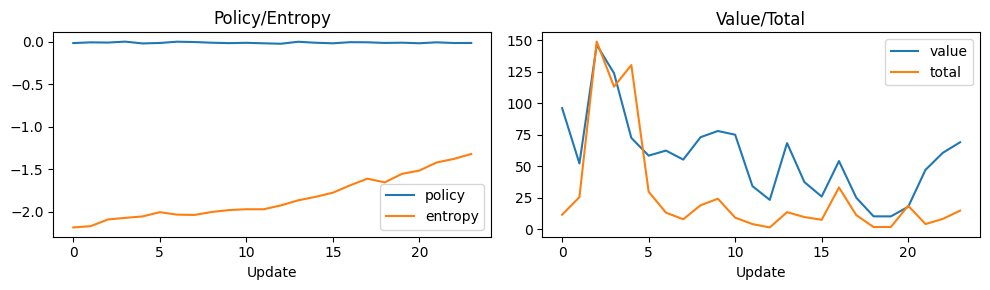

In [13]:
import csv
import os

log_path = os.path.join(log_dir, "progress.csv")
if not os.path.exists(log_path):
    print(f"No progress.csv found at {log_path}. Did training run?")
else:
    with open(log_path, "r", newline="") as f:
        rows = list(csv.DictReader(f))

    def get_series(key: str):
        vals = []
        for r in rows:
            v = r.get(key, "")
            if v != "" and v is not None:
                vals.append(float(v))
        return vals

    policy_loss = get_series("train/policy_gradient_loss")
    value_loss = get_series("train/value_loss")
    entropy_loss = get_series("train/entropy_loss")
    total_loss = get_series("train/loss")

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    if policy_loss:
        axes[0].plot(policy_loss, label="policy")
    if entropy_loss:
        axes[0].plot(entropy_loss, label="entropy")
    axes[0].set_title("Policy/Entropy")
    axes[0].set_xlabel("Update")
    axes[0].legend()

    if value_loss:
        axes[1].plot(value_loss, label="value")
    if total_loss:
        axes[1].plot(total_loss, label="total")
    axes[1].set_title("Value/Total")
    axes[1].set_xlabel("Update")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Generate a rollout GIF to visualize the FM-driven rotation trajectory.

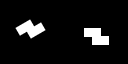

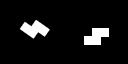

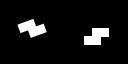

['gifs/rotation_ppo_tetris_fm_episode_sample_1.gif',
 'gifs/rotation_ppo_tetris_fm_episode_sample_2.gif',
 'gifs/rotation_ppo_tetris_fm_episode_sample_3.gif']

In [18]:
import imageio.v2 as imageio
import time
from IPython.display import Image, display


def render_pair_frame(source: torch.Tensor, target: torch.Tensor) -> np.ndarray:
    # Return a side-by-side frame (H, 2W, 3) as uint8.
    src = (source.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    tgt = (target.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    return np.concatenate([src, tgt], axis=1)


def rollout_and_save_gif(
    env: RotationEnvFM,
    model: PPO,
    out_path: str = "gifs/rotation_ppo_tetris_fm_episode.gif",
    seed: Optional[int] = None,
    max_steps: int = 360,
    fps: int = 8,
):
    if seed is not None:
        set_seed(seed)
    obs, _ = env.reset()
    frames = []

    for _ in range(max_steps):
        frames.append(render_pair_frame(env.current_source_obs[0], env.target_obs[0]))
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(int(action))
        if terminated or truncated:
            frames.append(render_pair_frame(env.current_source_obs[0], env.target_obs[0]))
            break

    imageio.mimsave(out_path, frames, fps=fps)
    return out_path


gif_env = RotationEnvFM(
    image_shape=image_shape,
    fm_model=fm_model,
    dino_model=dino,
    fm_steps=10,
    max_steps=180,
    epsilon=0.03,
    device=device,
    pair_sampler=sampler,
)

gif_paths = []
base_seed = int(time.time()) % 1000000
for i in range(3):
    out_path = f"gifs/rotation_ppo_tetris_fm_episode_sample_{i+1}.gif"
    gif_paths.append(rollout_and_save_gif(gif_env, model, out_path=out_path, seed=base_seed + i))

for p in gif_paths:
    display(Image(filename=p))

gif_paths